In [1]:
# !pip install plotly
# !pip install pandas
import pandas as pd
# !pip install pandas_ta
# import pandas_ta as ta
import numpy as np
# !pip install seaborn
import seaborn as sns
import datetime
from datetime import timedelta
import math
import requests
import plotly as py
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt


import sklearn as sk
import sklearn.preprocessing
from sklearn import metrics
from matplotlib.pyplot import figure

from sklearn.preprocessing import  (StandardScaler, MinMaxScaler, LabelBinarizer)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LogisticRegression
import xgboost as xgb
from sklearn.metrics import *
# from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import tree
from sklearn import decomposition
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

# !pip install keras
# !pip install tensorflow
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional

# !pip install graphviz
# import graphviz
# import chart_studio.tools as tls

# Creating DataFrame

In [2]:
#manipulatable variables
numDaysBack = str(365*5) #for daily you can go back multiple years worth, for daily you can only go back 90 days
myInterval = 'daily' # options are daily or hourly
theCoins = ['ethereum'] #can add more than one coin if you like
window_length = 14
mycom = 0.4
lower_macd_ema = 12
upper_macd_ema = 26
trigger_macd_ema = 9


def df_builder_clean(days, interval, coins):
    #manipulatable variables
    numDaysBack = days #for daily you can go back multiple years worth, for daily you can only go back 90 days
    myInterval = interval # options are daily or hourly
    theCoins = coins

    #builds initial dataframe with ethereum as first market but just to log the dates we are working with
    geckoReq = 'https://api.coingecko.com/api/v3/coins/ethereum/market_chart?vs_currency=usd&days='+numDaysBack+'&interval='+myInterval+''
    r = requests.get(geckoReq).json()
    ts = r['prices'][0][0]
    ts = ts/1000
    HistPricesList = []
    for i in range(len(r['prices'])):
        currentUnix = r['prices'][i][0] 
        price = r['prices'][i][1]
        currentUnix = currentUnix/1000
#         currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%d-%m-%Y %H:%M:%S") #adding dd-mm-yyyy hours minutes seconds
        currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%m-%d-%Y") #just the date mm-dd-yyyy
        HistPricesList.append([currentTS])
    global df
    df = pd.DataFrame(HistPricesList, columns = ['date'])

    
    #looping through each coin and adding in all data points and input variables
    for coin in theCoins:
        price_data(coin)
#         add_ewm(coin, mycom)
#         add_rsi(coin, window_length)
#         add_macd(coin, lower_macd_ema, upper_macd_ema, trigger_macd_ema)
        print('just added: ', coin)
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
#     print('r')
#     display(r)
    return df


def price_data(coin):
    global df
    # geckoReq = 'https://api.coingecko.com/api/v3/coins/ethereum/market_chart?vs_currency=usd&days=60&interval=daily'
    geckoReq = 'https://api.coingecko.com/api/v3/coins/'+coin+'/market_chart?vs_currency=usd&days='+numDaysBack+'&interval='+myInterval+''

    r = requests.get(geckoReq).json()
    ts = r['prices'][0][0]
    # print(ts)
    ts = ts/1000
    print(datetime.datetime.fromtimestamp(ts).strftime("%m-%d-%Y"))
    # print('prices length',len(r['prices']))
    HistPricesList = []
    for i in range(len(r['prices'])):
        currentUnix = r['prices'][i][0] 
        price = r['prices'][i][1]
        volume = r['total_volumes'][i][1]
        currentUnix = currentUnix/1000
        currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%m-%d-%Y")
    #     print('price: ', price, 'TS: ', currentTS)
        HistPricesList.append([currentTS, price, volume])
    #     currentUnix = currentTS
#         print(HistPricesList)
    dfCoin = pd.DataFrame(HistPricesList, columns = ['date', coin, coin+'_volume'])
#     print('dfCoin')
#     display(dfCoin)
    df = pd.merge(df, dfCoin[coin], left_on = df['date'], right_on=dfCoin['date']).drop(['key_0'], axis = 1)
    df = pd.merge(df, dfCoin[coin+'_volume'], left_on = df['date'], right_on=dfCoin['date']).drop(['key_0'], axis = 1)
    
def add_ewm(coin, mycom):
    df[coin+'_ewm'] = df[coin].ewm(com=mycom).mean()
    
def add_rsi(coin, window_length):
    global df
    df['diff'] = df[coin].diff(1)
    df['gain'] = df['diff'].clip(lower=0).round(2)
    df['loss'] = df['diff'].clip(upper=0).abs().round(2)
    
    # Get initial Averages
    df['avg_gain'] = df['gain'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]
    df['avg_loss'] = df['loss'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]

    # Get WMS averages
    # Average Gains
    for i, row in enumerate(df['avg_gain'].iloc[window_length+1:]):
        df['avg_gain'].iloc[i + window_length + 1] =\
            (df['avg_gain'].iloc[i + window_length] *
             (window_length - 1) +
             df['gain'].iloc[i + window_length + 1])\
            / window_length
    # Average Losses
    for i, row in enumerate(df['avg_loss'].iloc[window_length+1:]):
        df['avg_loss'].iloc[i + window_length + 1] =\
            (df['avg_loss'].iloc[i + window_length] *
             (window_length - 1) +
             df['loss'].iloc[i + window_length + 1])\
            / window_length
        
    df['rs'] = df['avg_gain'] / df['avg_loss']
    
    df['rsi'] = 100 - (100 / (1.0 + df['rs']))
    df = pd.DataFrame(df)
    df = df.drop(['gain', 'loss', 'avg_loss', 'avg_gain', 'rs'], axis = 1)
    
    #renaming diff and rsi columns
    dict = {'diff': coin+'_diff',
        'rsi': coin+'_rsi'}
    df.rename(columns=dict,
              inplace=True)

def add_macd(coin, lower_macd_ema, upper_macd_ema, trigger_macd_ema):
    global df
    #get ema for lower
    k = df[coin].ewm(span=lower_macd_ema, adjust = False, min_periods = lower_macd_ema).mean()

    #get ema for upper
    d = df[coin].ewm(span=upper_macd_ema, adjust=False, min_periods=upper_macd_ema).mean()

    macd = k-d
    
    # Get the 9-Day EMA of the MACD for the Trigger line
    macd_s = macd.ewm(span=trigger_macd_ema, adjust=False, min_periods=trigger_macd_ema).mean()
    # Calculate the difference between the MACD - Trigger for the Convergence/Divergence value
    macd_h = macd - macd_s
    # Add all of our new values for the MACD to the dataframe
    df['macd'] = df.index.map(macd)
    df['macd_h'] = df.index.map(macd_h)
    df['macd_s'] = df.index.map(macd_s)



mydf = pd.DataFrame(df_builder_clean(numDaysBack, myInterval, theCoins))
display(mydf)



08-09-2017
just added:  ethereum


,ethereum,ethereum_volume
date,,
2017-08-09,296.776724,4.485748e+08
2017-08-10,306.826433,4.116430e+08
2017-08-11,308.625531,4.854745e+08
2017-08-12,297.159803,6.890798e+08
2017-08-13,296.397290,3.844787e+08
...,...,...
2022-08-04,1612.418907,1.407456e+10
2022-08-05,1725.382627,1.771748e+10
2022-08-06,1693.296592,1.123110e+10


In [3]:
mydf.dropna(inplace=True)
# myCols = ['ethereum', 'ethereum_volume', 'ethereum_ewm', 'ethereum_rsi', 'macd', 'macd_h', 'macd_s', 'ethereum_diff']

In [4]:
my_data = mydf
# display(my_data.tail(10))
my_data.drop(my_data.tail(10).index,
        inplace = True)
display(my_data)

,ethereum,ethereum_volume
date,,
2017-08-09,296.776724,4.485748e+08
2017-08-10,306.826433,4.116430e+08
2017-08-11,308.625531,4.854745e+08
2017-08-12,297.159803,6.890798e+08
2017-08-13,296.397290,3.844787e+08
...,...,...
2022-07-25,1450.482285,1.985249e+10
2022-07-26,1438.988038,1.771199e+10
2022-07-27,1636.949181,2.279256e+10


# sliding window

### train test split and create sliding window

In [5]:
seq=list(mydf['ethereum'])
# display(seq)
scaler = StandardScaler()
window_size = 15
sliding_window=[]
for i in range(len(seq) - window_size + 1):
    sliding_window.append(seq[i: i + window_size])
    
# print(sliding_window)

sliding_df = pd.DataFrame(sliding_window)

sliding_df = sliding_df.drop(columns=[1,2,3,4,5])
display(sliding_df)
y = sliding_df[14]
X = sliding_df.drop(columns=[14]) 
X=scaler.fit_transform(X)
# print('X')
# display(X)
# print('y')
# display(y)
# X = X.shift(1, freq='d')
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=42)
X_train = X[:-360]
X_test = X[-360:]
y_train = y[:-360]
y_test = y[-360:]
print('X_train: ')
print(X_train.shape)
print('X_test: ')
print(X_test.shape)
print('y_train: ')
print(y_train.shape)
print('y_test: ')
print(y_test.shape)


,0,6,7,8,9,10,11,12,13,14
0,296.776724,300.039329,300.570344,296.114635,296.622090,295.171577,322.201220,312.174471,316.788920,321.785298
1,306.826433,300.570344,296.114635,296.622090,295.171577,322.201220,312.174471,316.788920,321.785298,329.025281
2,308.625531,296.114635,296.622090,295.171577,322.201220,312.174471,316.788920,321.785298,329.025281,329.865783
3,297.159803,296.622090,295.171577,322.201220,312.174471,316.788920,321.785298,329.025281,329.865783,343.341337
4,296.397290,295.171577,322.201220,312.174471,316.788920,321.785298,329.025281,329.865783,343.341337,344.201131
...,...,...,...,...,...,...,...,...,...,...
1797,1097.449438,1344.720284,1570.658959,1542.629821,1527.413931,1576.825239,1536.124922,1552.496489,1601.207967,1450.482285
1798,1040.797146,1570.658959,1542.629821,1527.413931,1576.825239,1536.124922,1552.496489,1601.207967,1450.482285,1438.988038
1799,1112.920783,1542.629821,1527.413931,1576.825239,1536.124922,1552.496489,1601.207967,1450.482285,1438.988038,1636.949181
1800,1191.130837,1527.413931,1576.825239,1536.124922,1552.496489,1601.207967,1450.482285,1438.988038,1636.949181,1723.548521


X_train: 
(1442, 9)
X_test: 
(360, 9)
y_train: 
(1442,)
y_test: 
(360,)


### xgboost on sliding window

Root Mean squared error train: 339.86
Root Mean squared error test: 1371.27
r2_score train:  0.7681825848670073
r2_score test:  -1.0331906813951361
               14
1442  2724.532243
1443  2821.649693
1444  2888.732274
1445  3151.217517
1446  3012.308559
...           ...
1797  1450.482285
1798  1438.988038
1799  1636.949181
1800  1723.548521
1801  1739.042177

[360 rows x 1 columns]


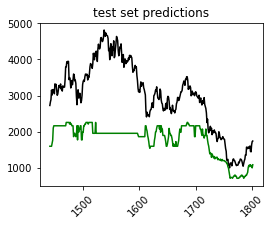

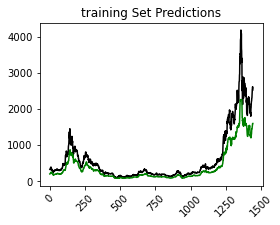

In [6]:

xg_reg=xgb.XGBRegressor(objective='reg:squarederror',colsample_bytree=0.3, learning_rate=0.1,
                        max_depth=5,alpha=10,n_estimators=10)
xg_reg.fit(X_train,y_train)
y_pred_test=xg_reg.predict(X_test)
y_pred_train=xg_reg.predict(X_train)
# rmse=np.sqrt(mean_squared_error(y_test,preds))
# print(preds)
# print(y_check1)
# print('xgb rmse: ', rmse)

print("Root Mean squared error train: %.2f" % math.sqrt(mean_squared_error(y_train, y_pred_train)))
print("Root Mean squared error test: %.2f" % math.sqrt(mean_squared_error(y_test, y_pred_test)))

print('r2_score train: ', r2_score(y_train, y_pred_train))
print('r2_score test: ', r2_score(y_test, y_pred_test))


y_testc = pd.DataFrame(y_test)
# print(y_check1)
print(y_testc)
y_testc['pred_linear_reg']= y_pred_test
# print(y_check1)
figure(figsize=(4, 3))
plt.plot(y_testc.index,y_testc[14], color = 'black')
plt.plot(y_testc.index,y_testc['pred_linear_reg'], color = 'green')
plt.xticks(rotation=45)
plt.title('test set predictions')
plt.show()


y_trainc = pd.DataFrame(y_train)
# print(y_check1)
y_trainc['pred_linear_reg']= y_pred_train
# print(y_check1)
figure(figsize=(4, 3))
plt.plot(y_trainc.index,y_trainc[14], color = 'black')
plt.plot(y_trainc.index,y_trainc['pred_linear_reg'], color = 'green')
plt.xticks(rotation=45)
plt.title('training Set Predictions')

plt.show()

## hyperparameter tuning on sliding windows feature set

In [7]:
parameters = {
    'max_depth': range (2, 10, 1),
    'booster': ['gbtree', 'gblinear'],
#     'n_estimators': range(0, 1000, 50),
    'n_estimators': [10,50,60,200,500,1000],
    'learning_rate': [0.1, 0.01, 0.05]
#     'eval_metric': ['rmse', 'mae', 'mape']
}
grid_search = GridSearchCV(
    estimator=xg_reg,
    param_grid=parameters,
#     scoring = 'roc_auc',
    n_jobs = 10,
    cv = 5,
    verbose=True
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(alpha=10, base_score=0.5, booster='gbtree',
                                    callbacks=None, colsample_bylevel=1,
                                    colsample_bynode=1, colsample_bytree=0.3,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=0, gpu_id=-1, grow_policy='depthwise',
                                    importance_type=None,
                                    interaction_constraints='',
                                    learning_rate=0.1, max_bin=256,
                                    max_...ta_step=0,
                                    max_depth=5, max_leaves=0,
                                    min_child_weight=1, missing=nan,
                                    monotone_constraints='()', n_estimators=10,
                                    n_jobs=0, num_parallel_tree=1,
  

Root Mean squared error train: 40.85
Root Mean squared error test: 475.32
r2_score train:  0.996650218434205
r2_score test:  0.7557150479887408


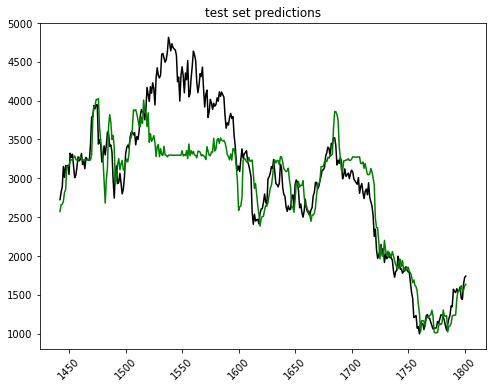

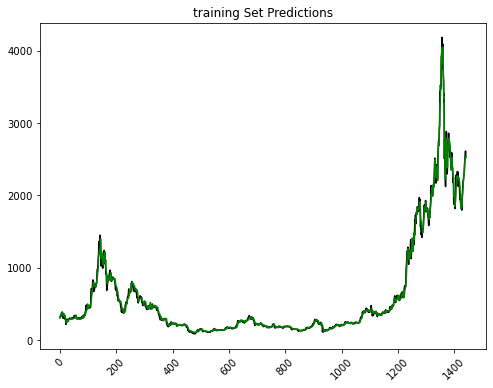

In [8]:
grid_search.best_estimator_
grid_search.best_estimator_.fit(X_train, y_train)
y_pred_test = grid_search.best_estimator_.predict(X_test)
y_pred_train = grid_search.best_estimator_.predict(X_train)
# rmse=np.sqrt(mean_squared_error(y_test,y_pred))

print("Root Mean squared error train: %.2f" % math.sqrt(mean_squared_error(y_train, y_pred_train)))
print("Root Mean squared error test: %.2f" % math.sqrt(mean_squared_error(y_test, y_pred_test)))

print('r2_score train: ', r2_score(y_train, y_pred_train))
print('r2_score test: ', r2_score(y_test, y_pred_test))

y_testc = pd.DataFrame(y_test)
# print(y_check1)
y_testc['pred_linear_reg']= y_pred_test
# print(y_check1)
figure(figsize=(8, 6))
plt.plot(y_testc.index,y_testc[14], color = 'black')
plt.plot(y_testc.index,y_testc['pred_linear_reg'], color = 'green')
plt.xticks(rotation=45)
plt.title('test set predictions')
plt.show()


y_trainc = pd.DataFrame(y_train)
# print(y_check1)
y_trainc['pred_linear_reg']= y_pred_train
# print(y_check1)
figure(figsize=(8, 6))
plt.plot(y_trainc.index,y_trainc[14], color = 'black')
plt.plot(y_trainc.index,y_trainc['pred_linear_reg'], color = 'green')
plt.xticks(rotation=45)
plt.title('training Set Predictions')

plt.show()

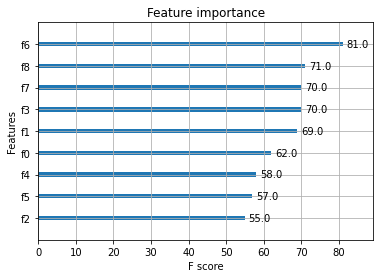

In [9]:
xgb.plot_importance(grid_search.best_estimator_)
plt.rcParams['figure.figsize']=[16,10]
plt.show()

# linear regression on sliding window

Root Mean squared error train: 56.38
Root Mean squared error test: 136.99
r2_score train:  0.9936211923900081
r2_score test:  0.9797074211230177
adjusted r2_score test: 0.9791856119518952


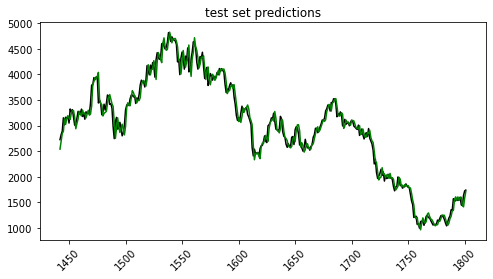

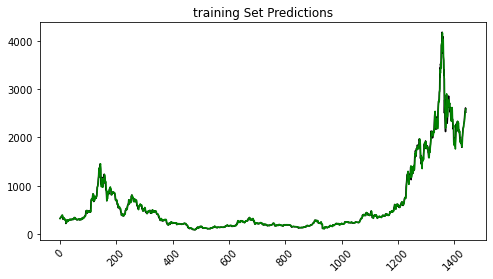

In [10]:
# print('linear regression with no scaling')
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred_test = regr.predict(X_test)
y_pred_train = regr.predict(X_train)
# The mean squared error
# print("Root Mean squared error: %.2f" % math.sqrt(mean_squared_error(y_test, y_pred)))

print("Root Mean squared error train: %.2f" % math.sqrt(mean_squared_error(y_train, y_pred_train)))
print("Root Mean squared error test: %.2f" % math.sqrt(mean_squared_error(y_test, y_pred_test)))

print('r2_score train: ', r2_score(y_train, y_pred_train))
print('r2_score test: ', r2_score(y_test, y_pred_test))
print('adjusted r2_score test:', 1-(1-r2_score(y_test, y_pred_test))*((len(X_test)-1)/(len(X_test)-len(X_test[0])-1)))

y_testc = pd.DataFrame(y_test)
# print(y_check1)
y_testc['pred_linear_reg']= y_pred_test
# print(y_check1)
figure(figsize=(8, 4))
plt.plot(y_testc.index,y_testc[14], color = 'black')
plt.plot(y_testc.index,y_testc['pred_linear_reg'], color = 'green')
plt.xticks(rotation=45)
plt.title('test set predictions')
plt.show()


y_trainc = pd.DataFrame(y_train)
# print(y_check1)
y_trainc['pred_linear_reg']= y_pred_train
# print(y_check1)
figure(figsize=(8, 4))
plt.plot(y_trainc.index,y_trainc[14], color = 'black')
plt.plot(y_trainc.index,y_trainc['pred_linear_reg'], color = 'green')
plt.xticks(rotation=45)
plt.title('training Set Predictions')

plt.show()

### The start of LSTM

Train Test Split

In [11]:
seq=list(mydf['ethereum'])
# display(seq)
# scaler = StandardScaler()
scaler = MinMaxScaler(feature_range = (0, 1))
window_size = 15
my_target = window_size-1
sliding_window=[]
for i in range(len(seq) - window_size + 1):
    sliding_window.append(seq[i: i + window_size])
    
# print(sliding_window)

sliding_df = pd.DataFrame(sliding_window)

sliding_df = sliding_df.drop(columns=[11,12,13])
display(sliding_df)

dataset = sliding_df

# We want 80% of the data to be used for training, and 20% for testing
n_train_rows = int(dataset.shape[0]*.8)-1

# Split into train and test sets but keep all 9 columns
train = dataset.iloc[:n_train_rows, :]
test = dataset.iloc[n_train_rows:, :]

# The total rows of the two datasets should equal the total amount of rows in your CSV
print(train.shape)
print(test.shape)

# Normalise features
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train.values)
test_set_scaled = sc.fit_transform(test.values)

,0,1,2,3,4,5,6,7,8,9,10,14
0,296.776724,306.826433,308.625531,297.159803,296.397290,288.450767,300.039329,300.570344,296.114635,296.622090,295.171577,321.785298
1,306.826433,308.625531,297.159803,296.397290,288.450767,300.039329,300.570344,296.114635,296.622090,295.171577,322.201220,329.025281
2,308.625531,297.159803,296.397290,288.450767,300.039329,300.570344,296.114635,296.622090,295.171577,322.201220,312.174471,329.865783
3,297.159803,296.397290,288.450767,300.039329,300.570344,296.114635,296.622090,295.171577,322.201220,312.174471,316.788920,343.341337
4,296.397290,288.450767,300.039329,300.570344,296.114635,296.622090,295.171577,322.201220,312.174471,316.788920,321.785298,344.201131
...,...,...,...,...,...,...,...,...,...,...,...,...
1797,1097.449438,1040.797146,1112.920783,1191.130837,1234.099139,1355.045640,1344.720284,1570.658959,1542.629821,1527.413931,1576.825239,1450.482285
1798,1040.797146,1112.920783,1191.130837,1234.099139,1355.045640,1344.720284,1570.658959,1542.629821,1527.413931,1576.825239,1536.124922,1438.988038
1799,1112.920783,1191.130837,1234.099139,1355.045640,1344.720284,1570.658959,1542.629821,1527.413931,1576.825239,1536.124922,1552.496489,1636.949181
1800,1191.130837,1234.099139,1355.045640,1344.720284,1570.658959,1542.629821,1527.413931,1576.825239,1536.124922,1552.496489,1601.207967,1723.548521


(1440, 12)
(362, 12)


In [12]:
steps = 50

# Prepare the training data
x_train = []
y_train = []

for i in range(steps, training_set_scaled.shape[0]-steps):
    x_train.append(training_set_scaled[i-steps:i, :])
    y_train.append(training_set_scaled[i, :])

x_train, y_train = np.array(x_train), np.array(y_train)
print(x_train.shape)


# Prepare the test data
x_test = []
y_test = []

for i in range(steps, test_set_scaled.shape[0]):
    x_test.append(test_set_scaled[i-steps:i, :])
    y_test.append(test_set_scaled[i, :])

x_test, y_test = np.array(x_test), np.array(y_test)
print(x_test.shape)

(1340, 50, 12)
(312, 50, 12)


In [ ]:
model = Sequential()

epochs = 10

model.add(LSTM(units=50, return_sequences = True, input_shape = (x_train.shape[1],12)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=12))
model.compile(loss="mse", optimizer="adam")
model.fit(x_train, y_train, batch_size = 32, epochs = epochs)
model.summary


Epoch 1/10
42/42 [==============================] - 17s 100ms/step - loss: 0.0079
Epoch 2/10
42/42 [==============================] - 6s 149ms/step - loss: 0.0030
Epoch 3/10
42/42 [==============================] - 8s 180ms/step - loss: 0.0025
Epoch 4/10
42/42 [==============================] - 7s 176ms/step - loss: 0.0023
Epoch 5/10
19/42 [============>.................] - ETA: 4s - loss: 0.0021

In [ ]:
print('\n# Evaluate on test data')
results = model.evaluate(x_test, y_test, batch_size=32)
print('test loss, test acc:', results)

In [ ]:
# Predict values from test data trained using training data
y_hat = model.predict(x_test)
y_hat = sc.inverse_transform(y_hat)

In [ ]:
display(y_hat.shape)